# Initial processing of MRI data

In [3]:
import numpy as np 
import nibabel as nib
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import torch
import numpy as np
import cv2
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
# import torchvision.utils as vutils
from torchvision import transforms
import time



In [4]:
nii_paths = pd.read_csv('/kaggle/input/nii-files-path/nii_paths.csv')
nii_paths = np.array(nii_paths['nii_path'])

In [5]:
img_arrs = []
for i in range(200):
    img = nib.load(nii_paths[i + 500])
    data = img.get_fdata()
    for j in range(40, 90):
        img_arrs.append(data[:, :, j])

In [6]:
img_arrs = np.array(img_arrs)
img_arrs.shape

(10000, 130, 130)

In [7]:
# cols = 10
# rows = (200 + cols - 1) // cols
# plt.figure(figsize=(cols, rows))

# # Load the NIfTI file
# for i in range(len(nii_paths[:200])):
#     plt.subplot(rows, cols, i + 1)
#     plt.imshow(img_arrs[i], cmap='gray')
#     plt.axis('off')
   
# plt.tight_layout()
# plt.show() 

# Set configuration parameters

In [5]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
LATENT_SIZE = 128       # Input noise vector size for G
IMG_SIZE = 128          # Output image size (must match preprocessing)
IMG_CHANNELS = 1        # Number of image channels (1 for grayscale MRI images)
EPOCHS = 60             # Number of training epochs (example)
BATCH_SIZE = 128        # Batch size
LR = 0.0001             # Learning rate (Adam: 1e-4 as described)
BETA1 = 0.5             # Adam beta1 parameter (as described)
BETA2 = 0.9             # Adam beta2 parameter (as described)
CRITIC_ITERATIONS = 4   # Number of D updates per G update
LAMBDA_GP = 10          # Gradient Penalty weight
SAMPLE_INTERVAL = 500   # Frequency to save sample images (in batches)
MODEL_SAVE_INTERVAL = 10 # Frequency to save model (in epochs)
OUTPUT_DIR = Path("/kaggle/working/mri_wgan_output")

# DUNG NOTE
DP_C = 1
DP_Z = 0.05


# Preprocessing data: Resize and Special normalization for MRI images

In [9]:
print(f"Starting specialized preprocessing for MRI images...")
start_time = time.time()

num_images = img_arrs.shape[0]
img_arrs_processed_np = np.empty((num_images, IMG_SIZE, IMG_SIZE), dtype=np.float32)

for i in range(num_images):
    img = img_arrs[i]
    p2, p98 = np.percentile(img, (2, 98))
    img_windowed = np.clip(img, p2, p98)
    denominator = (p98 - p2) + 1e-6  # Add a small epsilon
    img_normalized = (img_windowed - p2) / denominator
    img_resized = cv2.resize(img_normalized, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_CUBIC)
    img_final = img_resized * 2.0 - 1.0
    img_arrs_processed_np[i] = img_final

    if (i + 1) % 5000 == 0:
        print(f"  Processed {i + 1}/{num_images} images...")

img_arrs_processed_np = np.expand_dims(img_arrs_processed_np, axis=1)
img_tensor = torch.from_numpy(img_arrs_processed_np)


Bắt đầu tiền xử lý chuyên biệt cho ảnh MRI...
  Đã xử lý 5000/10000 ảnh...
  Đã xử lý 10000/10000 ảnh...


In [10]:
# import matplotlib.pyplot as plt

# cols = 10
# rows = (len(img_arrs[:300]) + cols - 1) // cols
# plt.figure(figsize=(cols, rows))

# for i in range(len(img_arrs_processed_np[:300])):
#     plt.subplot(rows, cols, i + 1)
#     plt.imshow(img_arrs_processed_np[i + 100][0], cmap='gray')
#     plt.axis('off')

# plt.tight_layout()
# plt.show()

# Create DataLoader

In [11]:
print("Tạo DataLoader...")
real_dataset = TensorDataset(img_tensor)
dataloader = DataLoader(
    real_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)
print(f"DataLoader sẵn sàng với {len(dataloader)} batches.")

Tạo DataLoader...
DataLoader sẵn sàng với 79 batches.


# Create Generator

In [8]:
import torch
import numpy as np
import cv2
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
import torchvision.utils as vutils
from torchvision import transforms
import matplotlib.pyplot as plt
import time
from pathlib import Path

In [9]:
class Generator(nn.Module):
    def __init__(self, latent_size, img_channels, img_size, features_g=64):
        """
        Initialize the Generator.
        Args:
            latent_size (int): Size of the noise vector z.
            img_channels (int): Number of channels of the output image (e.g., 1 for grayscale).
            img_size (int): Size (height/width) of the output image.
            features_g (int): Base number of features for convolutional layers.
        """
        super(Generator, self).__init__()
        self.img_size = img_size
        self.init_size = img_size // 16  # Initial spatial size (e.g., 128 // 16 = 8)
        self.latent_size = latent_size
        self.img_channels = img_channels

        # Initial Dense layer to transform the noise vector z
        # Output: features_g * 8 * init_size * init_size
        self.fc = nn.Sequential(
            nn.Linear(latent_size, features_g * 8 * self.init_size * self.init_size),
            # BatchNorm1d applied on flattened features
            nn.BatchNorm1d(features_g * 8 * self.init_size * self.init_size),
            nn.LeakyReLU(0.2, inplace=True)
        )

        # Sequence of ConvTranspose2d blocks to upsample
        self.conv_blocks = nn.Sequential(
            # Input: (N, features_g * 8, init_size, init_size) - e.g. (N, 512, 8, 8)
            # Block 1: init_size -> init_size * 2 (e.g., 8x8 -> 16x16)
            nn.ConvTranspose2d(features_g * 8, features_g * 4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(features_g * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # -> (N, features_g * 4, init_size*2, init_size*2) - e.g. (N, 256, 16, 16)

            # Block 2: init_size * 2 -> init_size * 4 (e.g., 16x16 -> 32x32)
            nn.ConvTranspose2d(features_g * 4, features_g * 2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(features_g * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # -> (N, features_g * 2, init_size*4, init_size*4) - e.g. (N, 128, 32, 32)

            # Block 3: init_size * 4 -> init_size * 8 (e.g., 32x32 -> 64x64)
            nn.ConvTranspose2d(features_g * 2, features_g, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(features_g),
            nn.LeakyReLU(0.2, inplace=True),
            # -> (N, features_g, init_size*8, init_size*8) - e.g. (N, 64, 64, 64)

            # Block 4: init_size * 8 -> init_size * 16 (img_size) (e.g., 64x64 -> 128x128)
            nn.ConvTranspose2d(features_g, img_channels, kernel_size=4, stride=2, padding=1, bias=False),
            # -> (N, img_channels, img_size, img_size) - e.g. (N, 1, 128, 128)

            # Final activation is Tanh to scale values to [-1, 1]
            nn.Tanh()
        )
        print("Generator initialized:")
        print(f" - Latent size: {latent_size}")
        print(f" - Initial spatial size: {self.init_size}x{self.init_size}")
        print(f" - Base features: {features_g}")
        print(f" - Output image size: {img_size}x{img_size}x{img_channels}")


    def forward(self, z):
        """
        Data flow through the Generator.
        Args:
            z (Tensor): Input noise vector, shape (batch_size, latent_size).
        Returns:
            Tensor: Generated image, shape (batch_size, img_channels, img_size, img_size).
        """
        # 1. Through Dense layer and reshape
        out = self.fc(z)
        # Reshape to (batch_size, features, init_size, init_size)
        out = out.view(out.size(0), -1, self.init_size, self.init_size)

        # 2. Through ConvTranspose blocks
        img = self.conv_blocks(out)
        return img


In [14]:
def test_generator(generator_class, latent_size, img_channels, img_size, batch_size, device, output_dir):
    """
    Kiểm tra hoạt động cơ bản của class Generator.

    Args:
        generator_class: Class Generator cần kiểm tra.
        latent_size (int): Kích thước vector nhiễu.
        img_channels (int): Số kênh ảnh output.
        img_size (int): Kích thước ảnh output.
        batch_size (int): Số lượng ảnh mẫu để tạo trong một lần test.
        device (torch.device): Thiết bị (CPU/GPU) để chạy test.
        output_dir (Path): Thư mục để lưu ảnh mẫu.
    """
    print("\n--- Testing Generator ---")
    try:
        # 1. Khởi tạo Generator
        generator = generator_class(latent_size, img_channels, img_size).to(device)
        generator.eval() # Chuyển sang chế độ đánh giá (quan trọng cho BatchNorm)
        print(f"Generator instantiated successfully on {device}.")

        # 2. Tạo nhiễu đầu vào
        test_noise = torch.randn(batch_size, latent_size, device=device)
        print(f"Input noise shape: {test_noise.shape}")

        # 3. Tạo ảnh giả (không cần tính gradient)
        with torch.no_grad():
            fake_images = generator(test_noise)
        print("Forward pass completed.")

        # 4. Kiểm tra shape output
        expected_shape = (batch_size, img_channels, img_size, img_size)
        if fake_images.shape == expected_shape:
            print(f"Output shape check: PASSED (Got: {fake_images.shape}, Expected: {expected_shape})")
        else:
            print(f"Output shape check: FAILED (Got: {fake_images.shape}, Expected: {expected_shape})")
            return False # Dừng test nếu shape sai

        # 5. Kiểm tra khoảng giá trị pixel
        min_val, max_val = fake_images.min().item(), fake_images.max().item()
        print(f"Output value range: [{min_val:.4f}, {max_val:.4f}]")
        if min_val >= -1.0 and max_val <= 1.0:
             print("Value range check: PASSED (within [-1, 1] as expected from Tanh)")
        elif min_val >= -1.01 and max_val <= 1.01: # Cho phép sai số nhỏ
             print("Value range check: PASSED (within [-1.01, 1.01], close enough)")
        else:
             print("Value range check: WARNING (Outside [-1, 1]. Check Tanh activation or potential issues.)")

        # 6. Lưu ảnh mẫu
        output_dir.mkdir(parents=True, exist_ok=True)
        sample_path = output_dir / "generator_test_samples.png"
        vutils.save_image(fake_images, sample_path, nrow=int(batch_size**0.5), normalize=True)
        print(f"Saved sample generator output grid to: {sample_path}")
        print("--- Generator Test Completed Successfully ---")
        
        # Dọn dẹp bộ nhớ (đặc biệt quan trọng nếu dùng GPU)
        del generator, test_noise, fake_images
        if torch.cuda.is_available():
             torch.cuda.empty_cache()
             
        return True

    except Exception as e:
        print(f"--- Generator Test FAILED ---")
        import traceback
        print(f"Error during generator test: {e}")
        traceback.print_exc()
        return False

In [15]:
test_batch_size = 16 # Hoặc 8, 4...
test_successful = test_generator(
    generator_class=Generator,
    latent_size=LATENT_SIZE,
    img_channels=IMG_CHANNELS,
    img_size=IMG_SIZE,
    batch_size=test_batch_size,
    device=DEVICE,
    output_dir=OUTPUT_DIR # Sử dụng thư mục output đã định nghĩa
)

if not test_successful:
    print("Generator test failed. Please review the errors before proceeding.")
    # Có thể thêm: raise RuntimeError("Generator test failed.") để dừng hẳn script nếu muốn


--- Testing Generator ---
Generator initialized:
 - Latent size: 128
 - Initial spatial size: 8x8
 - Base features: 64
 - Output image size: 128x128x1
Generator instantiated successfully on cuda.
Input noise shape: torch.Size([16, 128])
Forward pass completed.
Output shape check: PASSED (Got: torch.Size([16, 1, 128, 128]), Expected: (16, 1, 128, 128))
Output value range: [-0.0932, 0.1002]
Value range check: PASSED (within [-1, 1] as expected from Tanh)
Saved sample generator output grid to: /kaggle/working/mri_wgan_output/generator_test_samples.png
--- Generator Test Completed Successfully ---


# Create Discriminator

In [10]:
class Discriminator(nn.Module):
    def __init__(self, img_channels, img_size, features_d=64):
        """
        Initialize the Discriminator (Critic).
        Args:
            img_channels (int): Number of channels of the input image (e.g., 1 for grayscale).
            img_size (int): Size (height/width) of the input image.
            features_d (int): Base number of features for convolutional layers.
        """
        super(Discriminator, self).__init__()
        self.img_size = img_size
        self.img_channels = img_channels

        # Build a sequence of Conv2d layers to downsample
        # Important: Do NOT use BatchNorm in the WGAN-GP Critic
        self.conv_blocks = nn.Sequential(
            # Input: (N, img_channels, img_size, img_size) - e.g. (N, 1, 128, 128)

            # Block 1: 128x128 -> 64x64
            nn.Conv2d(img_channels, features_d, kernel_size=4, stride=2, padding=1, bias=False),
            # nn.LeakyReLU(0.2, inplace=True),
            nn.LeakyReLU(0.2),
            # -> (N, features_d, img_size/2, img_size/2) - e.g. (N, 64, 64, 64)

            # Block 2: 64x64 -> 32x32
            nn.Conv2d(features_d, features_d * 2, kernel_size=4, stride=2, padding=1, bias=False),
            # nn.LeakyReLU(0.2, inplace=True),
            nn.LeakyReLU(0.2),
            # -> (N, features_d*2, img_size/4, img_size/4) - e.g. (N, 128, 32, 32)

            # Block 3: 32x32 -> 16x16
            nn.Conv2d(features_d * 2, features_d * 4, kernel_size=4, stride=2, padding=1, bias=False),
            # nn.LeakyReLU(0.2, inplace=True),
            nn.LeakyReLU(0.2),
            # -> (N, features_d*4, img_size/8, img_size/8) - e.g. (N, 256, 16, 16)

            # Block 4: 16x16 -> 8x8
            nn.Conv2d(features_d * 4, features_d * 8, kernel_size=4, stride=2, padding=1, bias=False),
            # nn.LeakyReLU(0.2, inplace=True),
            nn.LeakyReLU(0.2),
            # -> (N, features_d*8, img_size/16, img_size/16) - e.g. (N, 512, 8, 8)

             # Block 5: 8x8 -> 4x4 (Add an extra layer if more depth is needed)
            nn.Conv2d(features_d * 8, features_d * 16, kernel_size=4, stride=2, padding=1, bias=False),
            # nn.LeakyReLU(0.2, inplace=True),
            nn.LeakyReLU(0.2),
            # -> (N, features_d*16, img_size/32, img_size/32) - e.g. (N, 1024, 4, 4)
        )

        # Final layer to output a scalar score
        # Input after flatten: features_d * 16 * (img_size/32) * (img_size/32)
        # Example: 1024 * 4 * 4 = 16384
        final_feature_map_size = img_size // 32
        self.fc = nn.Sequential(
            nn.Flatten(),
            # Optional Dense layer mentioned in original description (e.g. Dense(512) + LeakyReLU)
            # nn.Linear(features_d * 16 * final_feature_map_size * final_feature_map_size, 512),
            # nn.LeakyReLU(0.2, inplace=True),
            # nn.Linear(512, 1)

            # Or just a single linear layer without activation
             nn.Linear(features_d * 16 * final_feature_map_size * final_feature_map_size, 1)
             # NO activation here (output is the critic score)
        )

        print("Discriminator (Critic) initialized:")
        print(f" - Input image size: {img_size}x{img_size}x{img_channels}")
        print(f" - Base features: {features_d}")
        print(f" - Final feature map size before flatten: {final_feature_map_size}x{final_feature_map_size}")
        print(f" - Output: Scalar score")


    def forward(self, img):
        """
        Forward pass through the Discriminator.
        Args:
            img (Tensor): Input images (real or fake), shape (batch_size, img_channels, img_size, img_size).
        Returns:
            Tensor: Score (critic score) for each image, shape (batch_size, 1).
        """
        # 1. Through Conv2d blocks
        out = self.conv_blocks(img)
        # 2. Through the final fully connected layer
        score = self.fc(out)
        return score


# Custom weight initialization

In [17]:
def weights_init(m):
    """
    Custom weight initialization for Conv2d and BatchNorm2d layers.
    """
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


# Compute Loss

In [18]:
def compute_gradient_penalty(D, real_samples, fake_samples, device, lambda_gp):
    """
    Calculate the gradient penalty loss for WGAN-GP.
    Args:
        D (nn.Module): Discriminator (Critic).
        real_samples (Tensor): Batch of real images.
        fake_samples (Tensor): Batch of fake images.
        device (torch.device): Computing device (CPU/GPU).
        lambda_gp (float): Coefficient for gradient penalty.
    Returns:
        Tensor: Gradient penalty loss value.
    """
    
    batch_size = real_samples.size(0)
    # Random alpha for interpolation
    alpha = torch.rand(batch_size, 1, 1, 1, device=device)
    # Create interpolated samples between real and fake images
    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True)
    # Get critic scores for interpolated samples
    d_interpolates = D(interpolates)
    # Fake gradient outputs since we want gradient of output w.r.t input
    fake = torch.ones(batch_size, 1, device=device, requires_grad=False)

    # Compute gradients of scores w.r.t. interpolated inputs
    gradients = autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,       # Retain graph for higher order derivatives if needed
        retain_graph=True,       # Retain graph for backprop of D's loss
        only_inputs=True,        # Only gradients of inputs required
    )[0]

    # Flatten gradients to compute norm
    gradients = gradients.view(gradients.size(0), -1)
    # Compute L2 norm of gradients and penalty
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean() * lambda_gp

    return gradient_penalty


In [19]:
import os
os.makedirs(f"{OUTPUT_DIR}/images", exist_ok=True)
os.makedirs(f"{OUTPUT_DIR}/models", exist_ok=True)

# Training and Add Differential Privacy Inspired defend method

Generator initialized:
 - Latent size: 128
 - Initial spatial size: 8x8
 - Base features: 64
 - Output image size: 128x128x1
Discriminator (Critic) initialized:
 - Input image size: 128x128x1
 - Base features: 64
 - Final feature map size before flatten: 4x4
 - Output: Scalar score
Bắt đầu huấn luyện mô hình WGAN-GP MRI...
Training on cuda
Tham số: latent=128, batch_size=128, LR=0.0001
Differential Privacy (cắt gradient và thêm nhiễu) sẽ bắt đầu từ Epoch: 3
[Epoch 1/60] [Batch 0/79] [D loss: 9.2306] [G loss: -0.0803] [Real Score: 0.5336] [Fake Score: 0.0493]


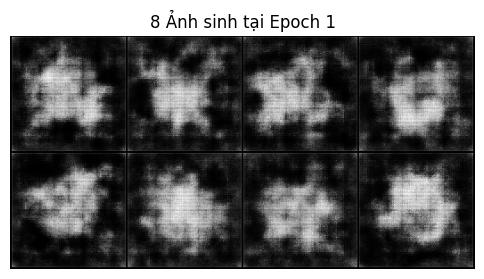

Epoch [1/60] - Thời gian: 138.22s
D Loss: -181.7102 | G Loss: -113.8847
Real Score: 404.7934 | Fake Score: 112.6964


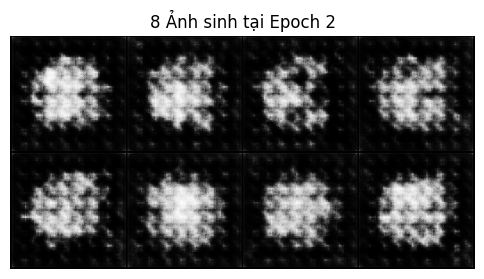

Epoch [2/60] - Thời gian: 138.07s
D Loss: -53.4603 | G Loss: -103.4493
Real Score: 177.8129 | Fake Score: 102.7934


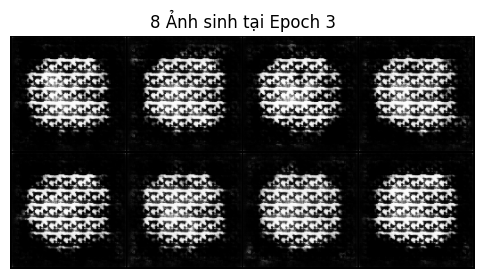

Epoch [3/60] - Thời gian: 138.54s
D Loss: 27.9599 | G Loss: -80.7103
Real Score: 65.3527 | Fake Score: 81.2030


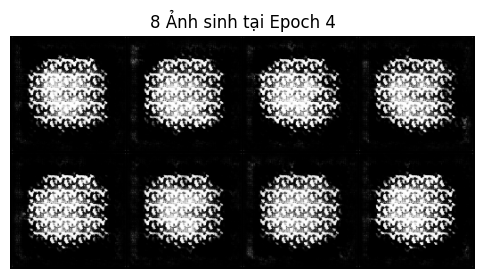

Epoch [4/60] - Thời gian: 138.28s
D Loss: 14.1335 | G Loss: -27.0611
Real Score: 14.3994 | Fake Score: 27.1824


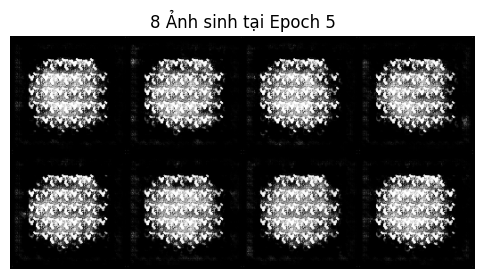

Epoch [5/60] - Thời gian: 138.22s
D Loss: 6.3957 | G Loss: -4.7090
Real Score: -1.4378 | Fake Score: 4.8519


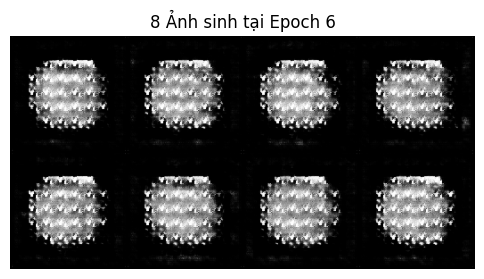

Epoch [6/60] - Thời gian: 138.31s
D Loss: 4.4676 | G Loss: 1.5135
Real Score: -5.9520 | Fake Score: -1.5280
[Epoch 7/60] [Batch 25/79] [D loss: 4.7637] [G loss: -14.2411] [Real Score: 9.6811] [Fake Score: 14.2667]


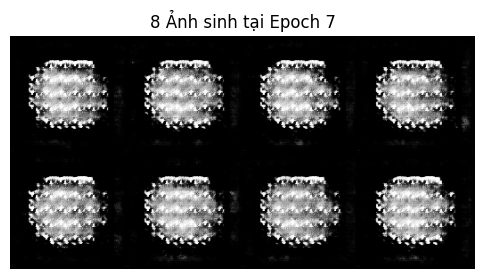

Epoch [7/60] - Thời gian: 138.65s
D Loss: 4.4798 | G Loss: -15.6954
Real Score: 11.3550 | Fake Score: 15.6548


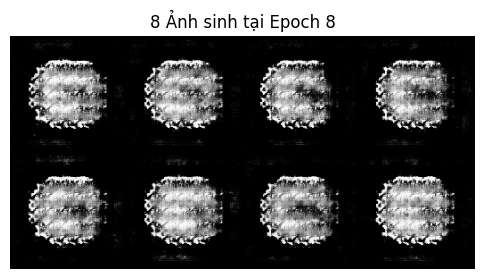

Epoch [8/60] - Thời gian: 138.31s
D Loss: 3.3885 | G Loss: -21.4723
Real Score: 18.2368 | Fake Score: 21.4828


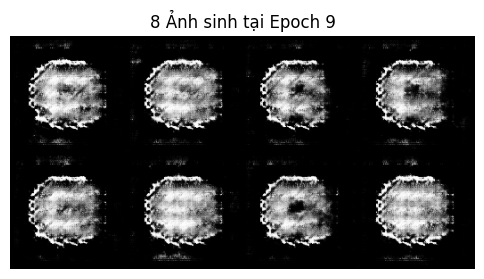

Epoch [9/60] - Thời gian: 138.23s
D Loss: 3.4909 | G Loss: -19.3644
Real Score: 16.0321 | Fake Score: 19.3829


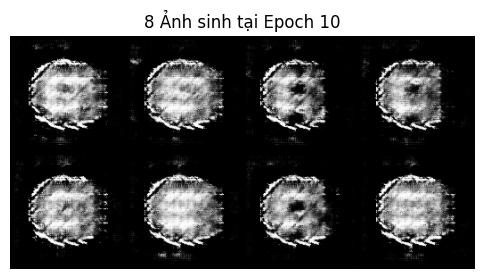

Epoch [10/60] - Thời gian: 138.89s
D Loss: 3.7274 | G Loss: -17.4272
Real Score: 13.9621 | Fake Score: 17.4389


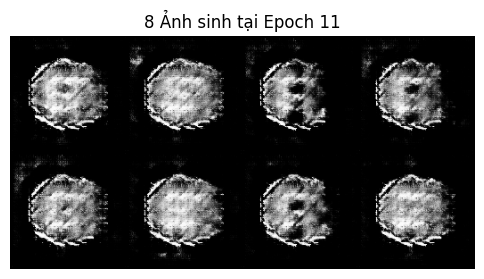

Epoch [11/60] - Thời gian: 138.26s
D Loss: 4.0329 | G Loss: -16.4811
Real Score: 12.7612 | Fake Score: 16.4845


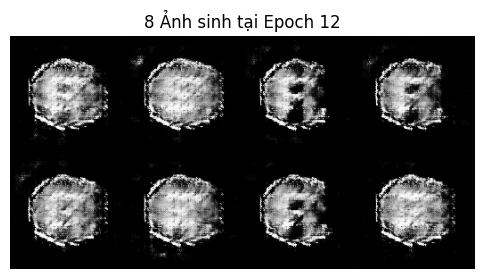

Epoch [12/60] - Thời gian: 138.30s
D Loss: 3.9041 | G Loss: -19.6203
Real Score: 16.0561 | Fake Score: 19.6031
[Epoch 13/60] [Batch 51/79] [D loss: 3.5340] [G loss: -25.8795] [Real Score: 22.7141] [Fake Score: 26.0701]


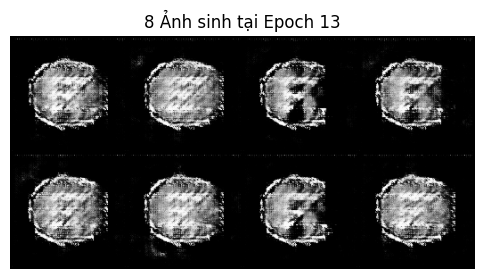

Epoch [13/60] - Thời gian: 138.55s
D Loss: 3.6065 | G Loss: -26.2626
Real Score: 22.8222 | Fake Score: 26.2707


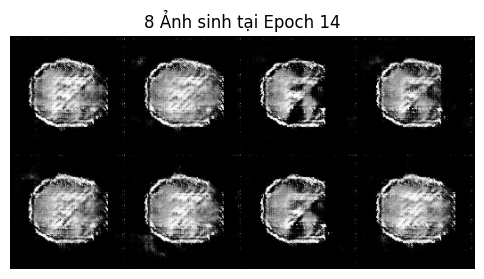

Epoch [14/60] - Thời gian: 138.27s
D Loss: 3.4507 | G Loss: -33.4315
Real Score: 30.0660 | Fake Score: 33.4276


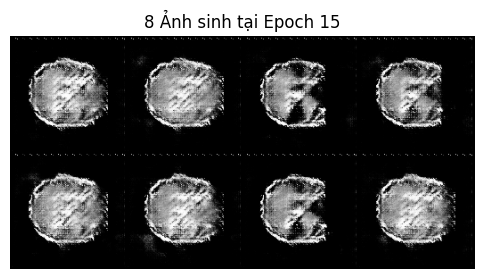

Epoch [15/60] - Thời gian: 138.20s
D Loss: 3.2126 | G Loss: -35.7450
Real Score: 32.5907 | Fake Score: 35.7474


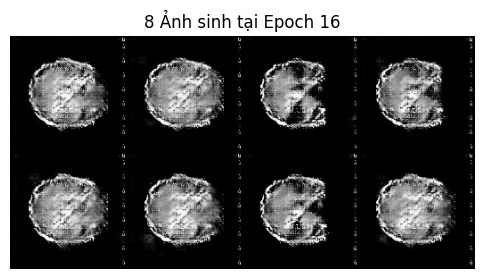

Epoch [16/60] - Thời gian: 138.23s
D Loss: 2.8747 | G Loss: -39.8689
Real Score: 37.0886 | Fake Score: 39.8968


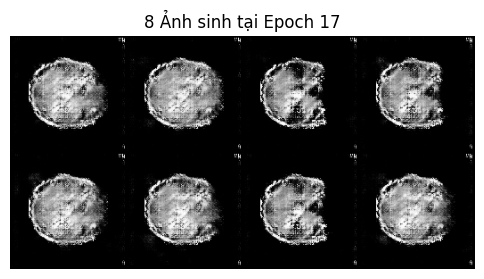

Epoch [17/60] - Thời gian: 138.28s
D Loss: 2.5229 | G Loss: -38.0912
Real Score: 35.5806 | Fake Score: 38.0585


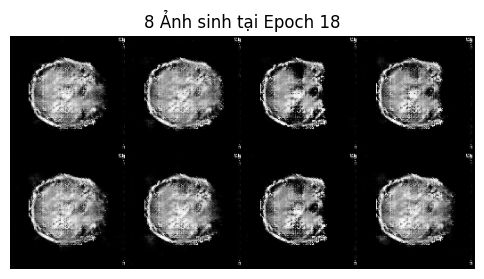

Epoch [18/60] - Thời gian: 138.29s
D Loss: 2.1091 | G Loss: -36.7877
Real Score: 34.6967 | Fake Score: 36.7787
[Epoch 19/60] [Batch 77/79] [D loss: 1.7465] [G loss: -35.8439] [Real Score: 34.0682] [Fake Score: 35.8128]


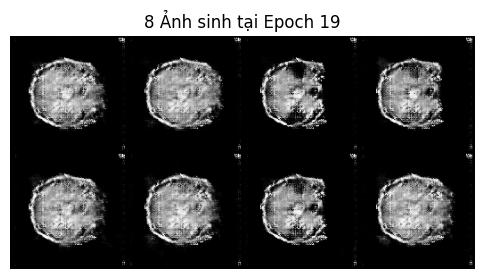

Epoch [19/60] - Thời gian: 138.54s
D Loss: 1.8523 | G Loss: -36.0053
Real Score: 34.1554 | Fake Score: 35.9845


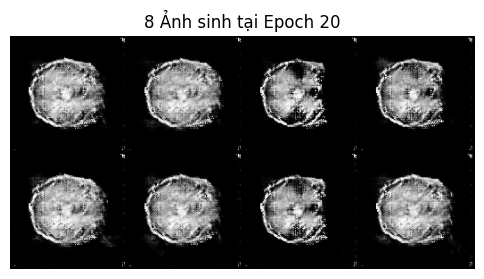

Epoch [20/60] - Thời gian: 138.83s
D Loss: 1.7264 | G Loss: -37.8295
Real Score: 36.1286 | Fake Score: 37.8308


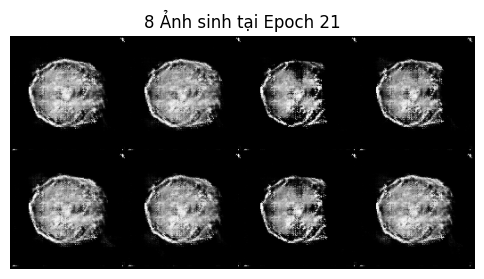

Epoch [21/60] - Thời gian: 138.18s
D Loss: 1.5276 | G Loss: -39.1005
Real Score: 37.6104 | Fake Score: 39.1182


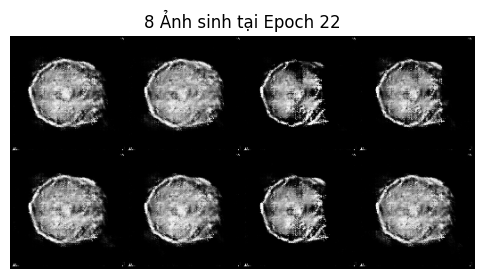

Epoch [22/60] - Thời gian: 138.18s
D Loss: 1.3780 | G Loss: -40.1535
Real Score: 38.8295 | Fake Score: 40.1911


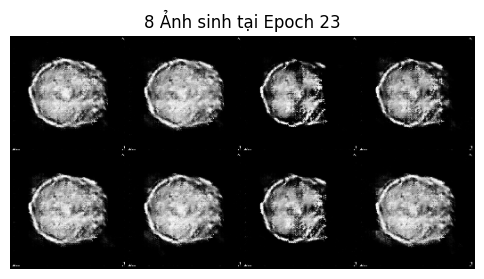

Epoch [23/60] - Thời gian: 138.21s
D Loss: 1.1921 | G Loss: -36.6586
Real Score: 35.5060 | Fake Score: 36.6734


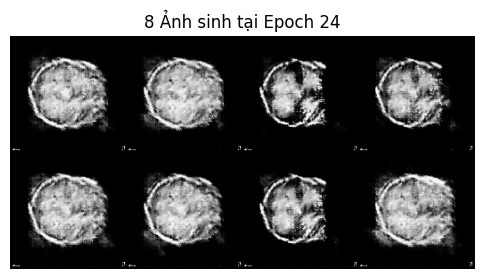

Epoch [24/60] - Thời gian: 138.25s
D Loss: 1.0043 | G Loss: -37.7770
Real Score: 36.8410 | Fake Score: 37.8199


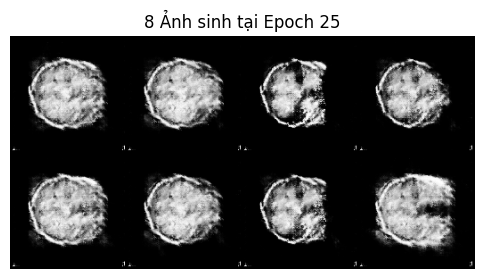

Epoch [25/60] - Thời gian: 138.19s
D Loss: 0.8730 | G Loss: -37.7423
Real Score: 36.8732 | Fake Score: 37.7316
[Epoch 26/60] [Batch 24/79] [D loss: 0.8302] [G loss: -35.3386] [Real Score: 34.1901] [Fake Score: 35.0196]


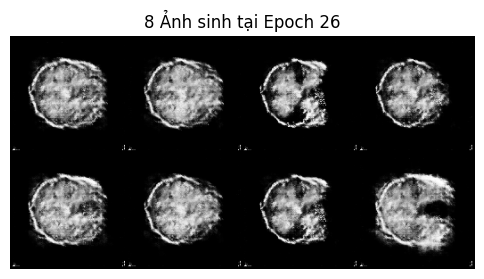

Epoch [26/60] - Thời gian: 138.48s
D Loss: 0.7991 | G Loss: -35.8630
Real Score: 35.0656 | Fake Score: 35.8530


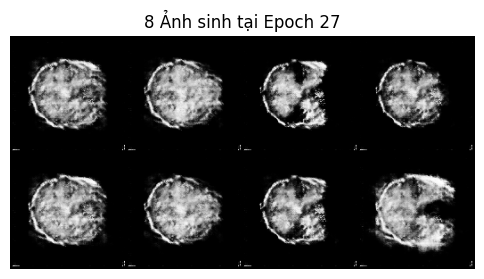

Epoch [27/60] - Thời gian: 138.30s
D Loss: 0.7380 | G Loss: -34.3509
Real Score: 33.6045 | Fake Score: 34.3259


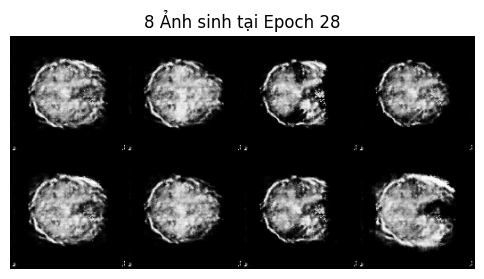

Epoch [28/60] - Thời gian: 138.21s
D Loss: 0.6868 | G Loss: -32.4419
Real Score: 31.7923 | Fake Score: 32.4676


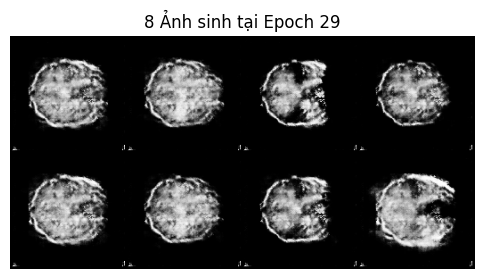

Epoch [29/60] - Thời gian: 138.22s
D Loss: 0.6370 | G Loss: -31.1707
Real Score: 30.5051 | Fake Score: 31.1285


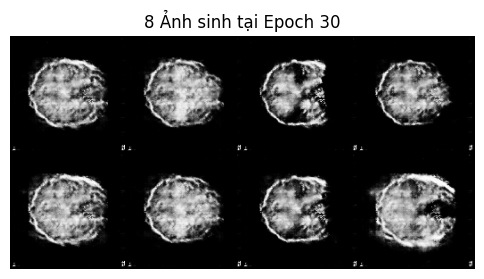

Epoch [30/60] - Thời gian: 138.84s
D Loss: 0.5753 | G Loss: -32.3424
Real Score: 31.7754 | Fake Score: 32.3407


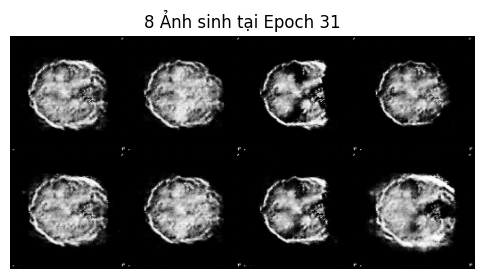

Epoch [31/60] - Thời gian: 138.26s
D Loss: 0.5232 | G Loss: -36.0382
Real Score: 35.5274 | Fake Score: 36.0450
[Epoch 32/60] [Batch 50/79] [D loss: 0.4890] [G loss: -34.2827] [Real Score: 33.2160] [Fake Score: 33.7042]


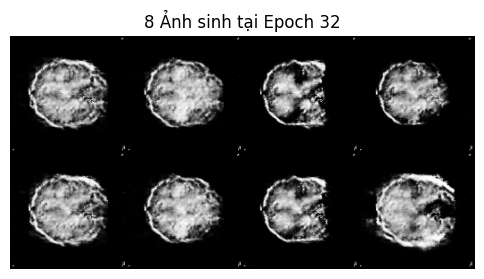

Epoch [32/60] - Thời gian: 138.50s
D Loss: 0.4608 | G Loss: -34.5634
Real Score: 34.1518 | Fake Score: 34.6059


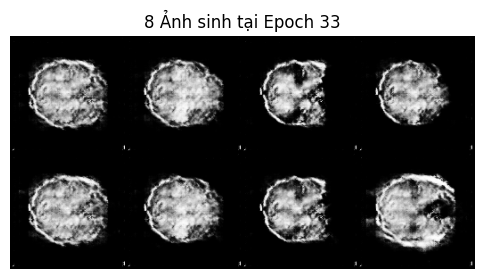

Epoch [33/60] - Thời gian: 138.17s
D Loss: 0.4601 | G Loss: -33.7170
Real Score: 33.2875 | Fake Score: 33.7428


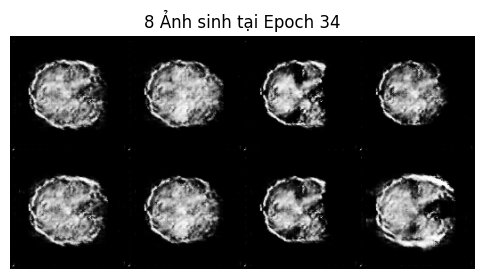

Epoch [34/60] - Thời gian: 138.22s
D Loss: 0.4243 | G Loss: -32.9082
Real Score: 32.5083 | Fake Score: 32.9271


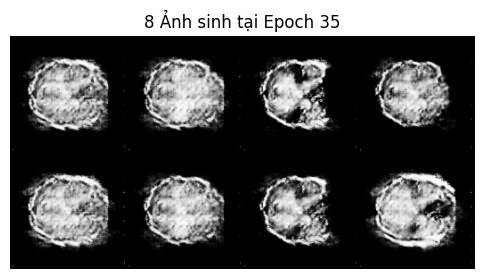

Epoch [35/60] - Thời gian: 138.22s
D Loss: 0.3918 | G Loss: -32.0074
Real Score: 31.6628 | Fake Score: 32.0489


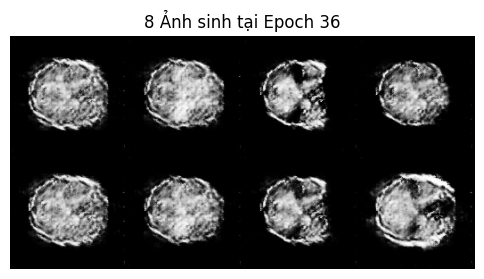

Epoch [36/60] - Thời gian: 138.13s
D Loss: 0.4165 | G Loss: -31.1106
Real Score: 30.7368 | Fake Score: 31.1488


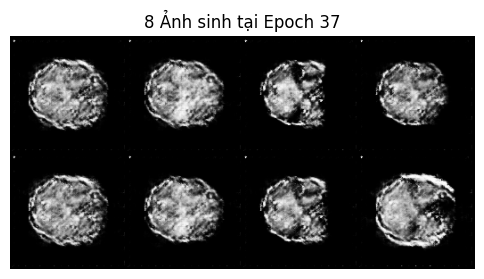

Epoch [37/60] - Thời gian: 138.20s
D Loss: 0.4634 | G Loss: -29.1926
Real Score: 28.7238 | Fake Score: 29.1825
[Epoch 38/60] [Batch 76/79] [D loss: 0.4586] [G loss: -30.5173] [Real Score: 30.7241] [Fake Score: 31.1824]


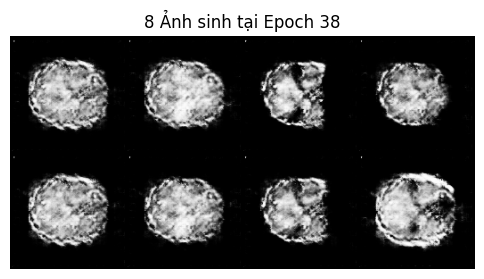

Epoch [38/60] - Thời gian: 138.50s
D Loss: 0.4701 | G Loss: -32.1983
Real Score: 31.7468 | Fake Score: 32.2136


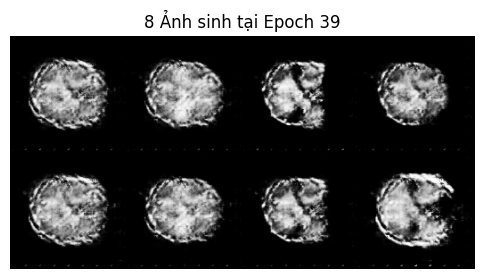

Epoch [39/60] - Thời gian: 138.23s
D Loss: 0.4705 | G Loss: -32.3424
Real Score: 31.8767 | Fake Score: 32.3442


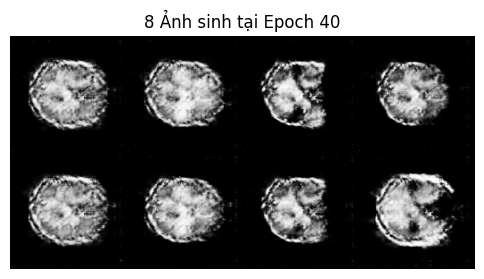

Epoch [40/60] - Thời gian: 138.58s
D Loss: 0.4813 | G Loss: -33.2204
Real Score: 32.7553 | Fake Score: 33.2330


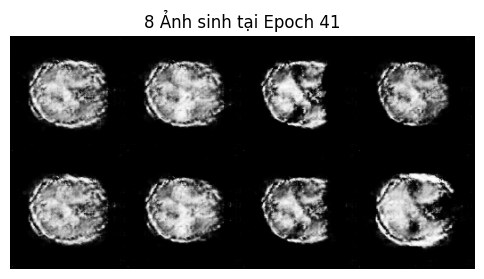

Epoch [41/60] - Thời gian: 138.21s
D Loss: 0.4876 | G Loss: -33.7346
Real Score: 33.2499 | Fake Score: 33.7329


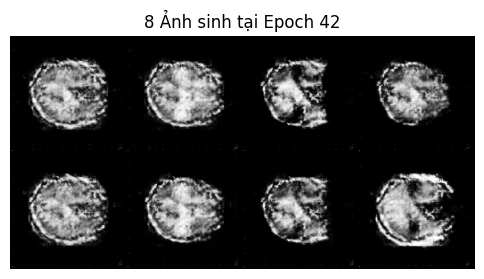

Epoch [42/60] - Thời gian: 138.26s
D Loss: 0.4969 | G Loss: -34.4860
Real Score: 33.9823 | Fake Score: 34.4745


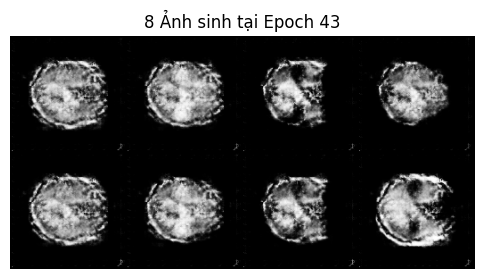

Epoch [43/60] - Thời gian: 138.26s
D Loss: 0.4868 | G Loss: -35.8076
Real Score: 35.3309 | Fake Score: 35.8136


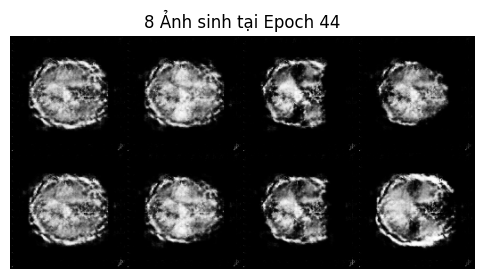

Epoch [44/60] - Thời gian: 138.18s
D Loss: 0.4629 | G Loss: -35.3538
Real Score: 34.8983 | Fake Score: 35.3584
[Epoch 45/60] [Batch 23/79] [D loss: 0.4731] [G loss: -32.7617] [Real Score: 32.5711] [Fake Score: 33.0377]


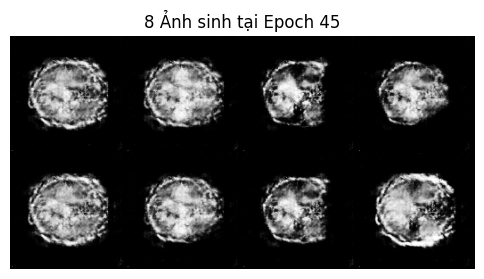

Epoch [45/60] - Thời gian: 138.45s
D Loss: 0.4557 | G Loss: -35.2590
Real Score: 34.8287 | Fake Score: 35.2802


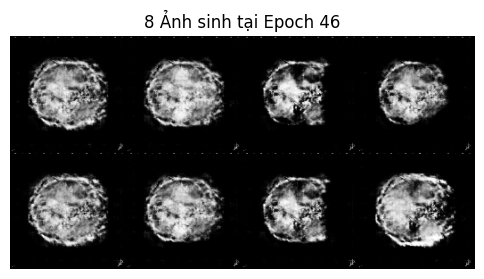

Epoch [46/60] - Thời gian: 138.14s
D Loss: 0.4664 | G Loss: -33.9570
Real Score: 33.4910 | Fake Score: 33.9522


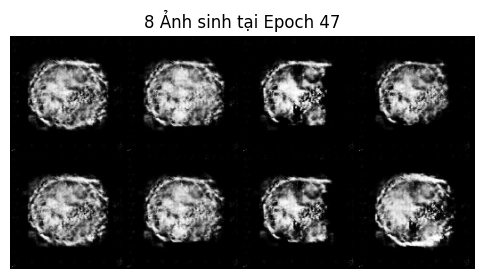

Epoch [47/60] - Thời gian: 138.19s
D Loss: 0.4810 | G Loss: -33.8164
Real Score: 33.3326 | Fake Score: 33.8082


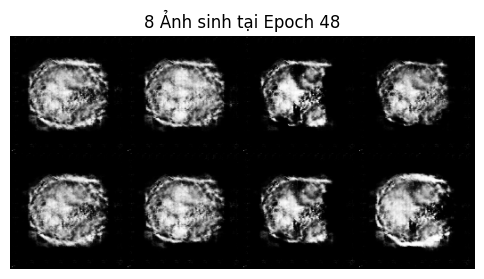

Epoch [48/60] - Thời gian: 138.19s
D Loss: 0.4812 | G Loss: -34.4514
Real Score: 33.9649 | Fake Score: 34.4421


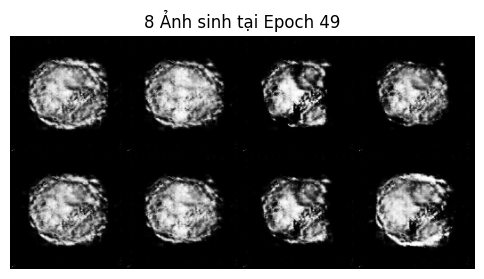

Epoch [49/60] - Thời gian: 138.18s
D Loss: 0.4715 | G Loss: -34.8090
Real Score: 34.3520 | Fake Score: 34.8186


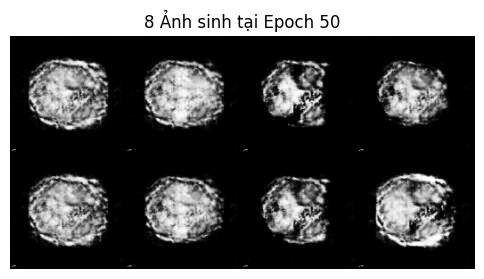

Epoch [50/60] - Thời gian: 138.54s
D Loss: 0.4690 | G Loss: -34.9059
Real Score: 34.4671 | Fake Score: 34.9285
[Epoch 51/60] [Batch 49/79] [D loss: 0.4708] [G loss: -34.7671] [Real Score: 34.0029] [Fake Score: 34.4672]


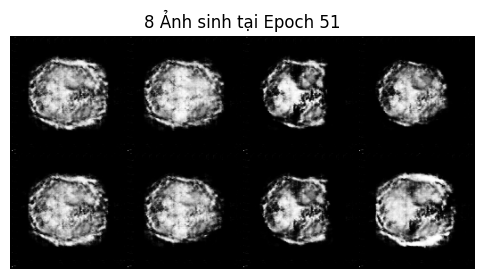

Epoch [51/60] - Thời gian: 138.44s
D Loss: 0.4557 | G Loss: -34.9985
Real Score: 34.5488 | Fake Score: 34.9997


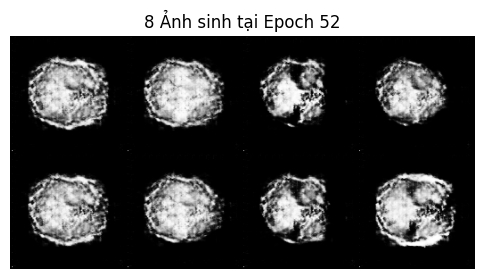

Epoch [52/60] - Thời gian: 138.16s
D Loss: 0.4412 | G Loss: -35.3997
Real Score: 34.9752 | Fake Score: 35.4109


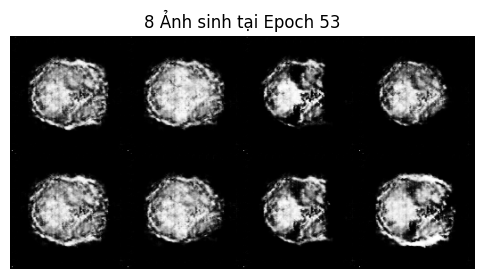

Epoch [53/60] - Thời gian: 138.16s
D Loss: 0.4142 | G Loss: -35.6577
Real Score: 35.2613 | Fake Score: 35.6713


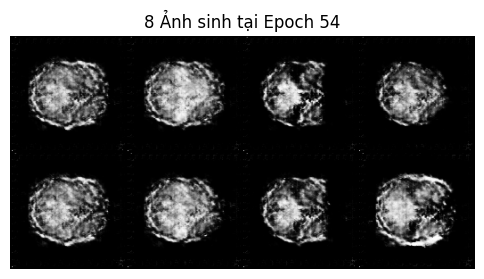

Epoch [54/60] - Thời gian: 138.19s
D Loss: 0.3869 | G Loss: -34.4008
Real Score: 34.0353 | Fake Score: 34.4148


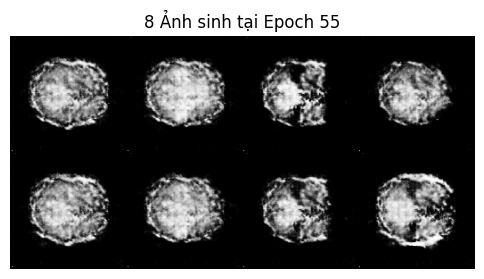

Epoch [55/60] - Thời gian: 138.20s
D Loss: 0.3485 | G Loss: -36.4246
Real Score: 36.1002 | Fake Score: 36.4323


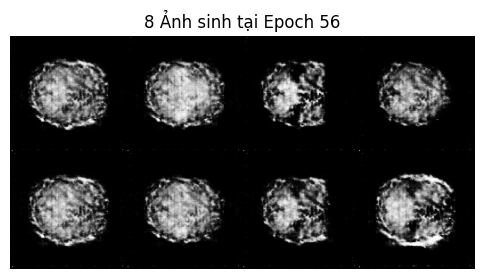

Epoch [56/60] - Thời gian: 138.24s
D Loss: 0.3425 | G Loss: -36.2550
Real Score: 36.0190 | Fake Score: 36.3473
[Epoch 57/60] [Batch 75/79] [D loss: 0.3771] [G loss: -44.1650] [Real Score: 43.8164] [Fake Score: 44.1874]


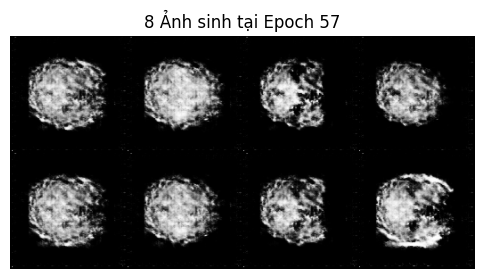

Epoch [57/60] - Thời gian: 138.52s
D Loss: 0.3469 | G Loss: -36.8514
Real Score: 36.5002 | Fake Score: 36.8360


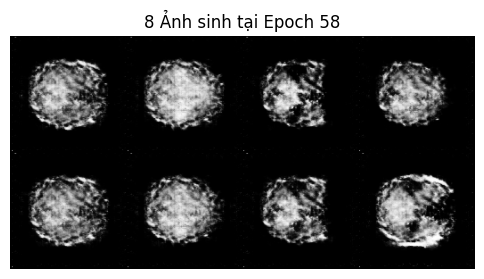

Epoch [58/60] - Thời gian: 138.29s
D Loss: 0.3307 | G Loss: -37.7037
Real Score: 37.4457 | Fake Score: 37.7648


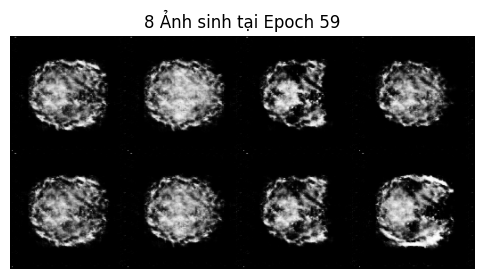

Epoch [59/60] - Thời gian: 138.16s
D Loss: 0.3232 | G Loss: -38.7228
Real Score: 38.4104 | Fake Score: 38.7262


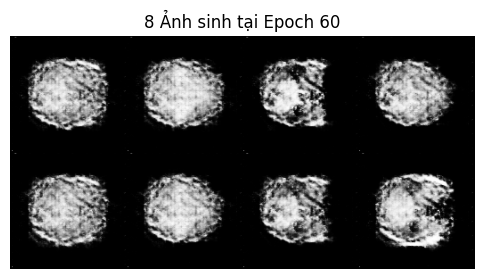

Epoch [60/60] - Thời gian: 138.59s
D Loss: 0.3599 | G Loss: -37.3070
Real Score: 36.9944 | Fake Score: 37.3440
Huấn luyện hoàn tất sau 138.35 phút


In [25]:
# Initialize model and optimizers
generator = Generator(LATENT_SIZE, IMG_CHANNELS, IMG_SIZE).to(DEVICE)
discriminator = Discriminator(IMG_CHANNELS, IMG_SIZE).to(DEVICE)

# Apply custom weight initialization
generator.apply(weights_init)
discriminator.apply(weights_init)

# Initialize optimizers
optimizer_g = optim.Adam(generator.parameters(), lr=LR, betas=(BETA1, BETA2))

# Define the epoch to start applying Differential Privacy
# DP will start from this epoch onward. Adjust this number as you like.
DP_START_EPOCH = 3 

# Initialize optimizer for Discriminator
optimizer_d = optim.Adam(discriminator.parameters(), lr=LR, betas=(BETA1, BETA2))

# No more code or comments related to Opacus here.
# If your Discriminator has BatchNorm layers, ensure they are configured properly for DP manually (track_running_stats=False if needed).
# print("\n--- Preparing Discriminator for manual Differential Privacy ---")
# for module in discriminator.modules():
#     if isinstance(module, nn.BatchNorm2d):
#         print("Warning: BatchNorm detected in Discriminator. Set track_running_stats=False.")
#         module.track_running_stats = False


# Initialize fixed noise to monitor progress
fixed_noise = torch.randn(64, LATENT_SIZE, device=DEVICE)

# Save loss history for later analysis
g_losses = []
d_losses = []
real_scores = []
fake_scores = []
# Completely remove 'epsilons' since not using Opacus for calculation.
# epsilons = [] 

print(f"Starting training WGAN-GP MRI model...")
print(f"Training on {DEVICE}")
print(f"Parameters: latent={LATENT_SIZE}, batch_size={BATCH_SIZE}, LR={LR}")
print(f"Differential Privacy (gradient clipping and noise addition) will start from Epoch: {DP_START_EPOCH}")


# total_batches = len(dataloader)
total_batches = len(dataloader)
global_step = 0
start_time = time.time()

for epoch in range(1, EPOCHS + 1):
    epoch_start_time = time.time()
    generator.train()
    discriminator.train()
    
    # Measure performance per epoch
    epoch_g_loss = 0.0
    epoch_d_loss = 0.0
    epoch_real_score = 0.0
    epoch_fake_score = 0.0
    batches_this_epoch = 0
    
    # for batch_idx, (real_imgs,) in enumerate(dataloader):
    for batch_idx, (real_imgs,) in enumerate(dataloader):
        batches_this_epoch += 1
        global_step += 1
        batch_size = real_imgs.size(0)
        real_imgs = real_imgs.to(DEVICE)
        
        # ---------------------
        # Train Discriminator (Critic)
        # ---------------------
        for _ in range(CRITIC_ITERATIONS):
            optimizer_d.zero_grad()
            
            # Compute scores for real images
            real_validity = discriminator(real_imgs)
            real_score = real_validity.mean().item()
            
            # Generate fake images
            z = torch.randn(batch_size, LATENT_SIZE, device=DEVICE)
            fake_imgs = generator(z)
            
            # Compute scores for fake images
            fake_validity = discriminator(fake_imgs.detach())
            fake_score = fake_validity.mean().item()
            
            # Compute Gradient Penalty
            gradient_penalty = compute_gradient_penalty(
                discriminator, real_imgs, fake_imgs.detach(), DEVICE, LAMBDA_GP
            )
            
            # Discriminator loss = -(real image score - fake image score) + GP
            d_loss = -torch.mean(real_validity) + torch.mean(fake_validity) + gradient_penalty
            
            # Backward
            d_loss.backward()
            
            # --- APPLY MANUAL DIFFERENTIAL PRIVACY (ONLY AFTER SPECIFIED EPOCH) ---
            # Always clip gradients to stabilize WGAN-GP.
            torch.nn.utils.clip_grad_norm_(discriminator.parameters(), DP_C)

            # Only add noise if current epoch >= DP_START_EPOCH
            if epoch >= DP_START_EPOCH:
                for p in discriminator.parameters():
                    if p.grad is not None:
                        # DP_C and DP_Z should be defined somewhere in your main code (e.g., as constants)
                        # Example: DP_C = 1.0 (clipping norm), DP_Z = 0.5 (noise scale)
                        noise = torch.randn_like(p.grad) * DP_C * DP_Z 
                        p.grad.add_(noise)
                        
            optimizer_d.step()
                    
        # ---------------------
        # Train Generator
        # ---------------------
        optimizer_g.zero_grad()
        
        # Generate new fake images
        z = torch.randn(batch_size, LATENT_SIZE, device=DEVICE)
        gen_imgs = generator(z)
        
        # Compute loss - we want to maximize critic's score on fake images
        validity = discriminator(gen_imgs)
        g_loss = -torch.mean(validity)
        
        # Backward and optimize
        g_loss.backward()
        optimizer_g.step()
        
        # Save loss info
        epoch_d_loss += d_loss.item()
        epoch_g_loss += g_loss.item()
        epoch_real_score += real_score
        epoch_fake_score += fake_score

        # Remove epsilon calculation since Opacus is not used
        # current_epsilon = privacy_engine_d.get_epsilon(DP_DELTA)
        # epsilons.append(current_epsilon)
        
        # Print info and save sample images periodically
        if global_step % SAMPLE_INTERVAL == 0 or (epoch == 1 and batch_idx == 0):
            # Set generator to eval mode to ensure BatchNorm doesn't update
            generator.eval()
            
            with torch.no_grad():
                fake_samples = generator(fixed_noise).detach().cpu()
            
            # Save sample images
            vutils.save_image(
                fake_samples,
                f"{OUTPUT_DIR}/images/samples_e{epoch:03d}_b{batch_idx:05d}.png",
                normalize=True,
                nrow=8
            )
            
            # Print progress info
            print(
                f"[Epoch {epoch}/{EPOCHS}] "
                f"[Batch {batch_idx}/{total_batches}] "
                f"[D loss: {d_loss.item():.4f}] "
                f"[G loss: {g_loss.item():.4f}] "
                f"[Real Score: {real_score:.4f}] "
                f"[Fake Score: {fake_score:.4f}]"
            )
            
            # Set generator back to train mode
            generator.train()
            
    # Display grid of 8 generated images after each epoch
    generator.eval()
    with torch.no_grad():
        fake_samples = generator(fixed_noise).detach().cpu()
    generator.train()
    
    # Select first 8 images
    grid_img = vutils.make_grid(fake_samples[:8], nrow=4, normalize=True)
    
    plt.figure(figsize=(6, 6))
    plt.axis("off")
    plt.title(f"8 Generated Images at Epoch {epoch}")
    
    # If grayscale image (1 channel), display with cmap='gray'
    if grid_img.shape[0] == 1:
        plt.imshow(grid_img.squeeze(), cmap='gray')
    else:
        plt.imshow(np.transpose(grid_img.numpy(), (1, 2, 0)))
    
    plt.show()
    
    # Calculate average values per epoch
    epoch_d_loss /= batches_this_epoch
    epoch_g_loss /= batches_this_epoch
    epoch_real_score /= batches_this_epoch
    epoch_fake_score /= batches_this_epoch
    
    # Save model state periodically
    if epoch % MODEL_SAVE_INTERVAL == 0:
        torch.save({
            'epoch': epoch,
            'generator_state_dict': generator.state_dict(),
            'discriminator_state_dict': discriminator.state_dict(),
            'optimizer_g_state_dict': optimizer_g.state_dict(),
            'optimizer_d_state_dict': optimizer_d.state_dict(),
            'g_loss': g_loss.item(),
            'd_loss': d_loss.item(),
            # 'epsilon': current_epsilon, # Uncomment if you want to save epsilon but you calculate it yourself
        }, f"{OUTPUT_DIR}/models/wgan_gp_mri_e{epoch:03d}.pt")
    
    # Save loss history for plotting later
    g_losses.append(epoch_g_loss)
    d_losses.append(epoch_d_loss)
    real_scores.append(epoch_real_score)
    fake_scores.append(epoch_fake_score)
    
    # Calculate epoch duration and print info
    epoch_time = time.time() - epoch_start_time
    
    print(f"Epoch [{epoch}/{EPOCHS}] - Time: {epoch_time:.2f}s")
    print(f"D Loss: {epoch_d_loss:.4f} | G Loss: {epoch_g_loss:.4f}")
    print(f"Real Score: {epoch_real_score:.4f} | Fake Score: {epoch_fake_score:.4f}")
    # Remove epsilon print since Opacus not used
    # print(f"Current Epsilon for epoch: {current_epsilon:.2f}") 
    
    # Plot loss every 10 epochs
    if epoch % 10 == 0:
        plt.figure(figsize=(12, 6)) # Smaller figure size since no epsilon plot
        
        plt.subplot(1, 2, 1) # Change to 2 columns
        plt.plot(g_losses, label='Generator')
        plt.plot(d_losses, label='Discriminator (DP Manual)') # Rename label
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Generator and Discriminator Loss (with Manual DP)') # Rename title
        plt.legend()
        
        plt.subplot(1, 2, 2) # New column
        plt.plot(real_scores, label='Real Scores')
        plt.plot(fake_scores, label='Fake Scores')
        plt.xlabel('Epoch')
        plt.ylabel('Score')
        plt.title('Discriminator Scores (with Manual DP)') # Rename title
        plt.legend()

        plt.tight_layout()
        plt.savefig(f"{OUTPUT_DIR}/loss_scores_manual_dp_e{epoch:03d}.png") # Rename file
        plt.close()

# End of training
training_time = time.time() - start_time
print(f"Training completed in {training_time/60:.2f} minutes")

# Save final model
torch.save({
    'generator_state_dict': generator.state_dict(),
    'discriminator_state_dict': discriminator.state_dict(),
    # 'final_epsilon': final_epsilon, # Uncomment if you want to save epsilon but you calculate it yourself
}, f"{OUTPUT_DIR}/models/wgan_gp_mri_final.pt")


# Plot summary graphs
plt.figure(figsize=(12, 6)) # Smaller figure size

plt.subplot(1, 2, 1)
plt.plot(g_losses, label='Generator')
plt.plot(d_losses, label='Discriminator (DP Manual)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Generator and Discriminator Loss (with Manual DP)')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(real_scores, label='Real Scores')
plt.plot(fake_scores, label='Fake Scores')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.title('Discriminator Scores (with Manual DP)')
plt.legend()

# Removed epsilon plot because Opacus is not used
# plt.subplot(2, 2, 3)
# plt.plot(np.arange(len(epsilons)) / total_batches, epsilons, label='Epsilon') 
# plt.xlabel('Epoch (approx)')
# plt.ylabel('Epsilon')
# plt.title('Accumulated Epsilon over Training')
# plt.legend()

plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/training_progress_summary_manual_dp.png")  # Renamed file
plt.close()

# Use pre-trained weights

In [71]:
# Initialize models with the same architecture as when saved
generator = Generator(LATENT_SIZE, IMG_CHANNELS, IMG_SIZE).to(DEVICE)
discriminator = Discriminator(IMG_CHANNELS, IMG_SIZE).to(DEVICE)

# --- 2. Define the checkpoint path ---
# Change this path to your .pt file
checkpoint_path = "/kaggle/input/dp-model/pytorch/default/1/wgan_gp_mri_e050.pt"
# Or a specific checkpoint file like 'wgan_gp_mri_e050.pt'

# --- 3. Load checkpoint ---
print(f"Loading checkpoint from: {checkpoint_path}")
try:
    # map_location=DEVICE helps load directly to the desired device
    checkpoint = torch.load(checkpoint_path, map_location=DEVICE)
    print("Checkpoint successfully loaded.")

    # --- 4. Load weights into the model ---
    # Check if the required keys exist
    if 'generator_state_dict' in checkpoint:
        print("Loading weights into Generator...")
        generator.load_state_dict(checkpoint['generator_state_dict'])
        print("Generator weights loaded.")
    else:
        print("WARNING: 'generator_state_dict' not found in checkpoint.")

    if 'discriminator_state_dict' in checkpoint:
        print("Loading weights into Discriminator...")
        discriminator.load_state_dict(checkpoint['discriminator_state_dict'])
        print("Discriminator weights loaded.")
    else:
        print("WARNING: 'discriminator_state_dict' not found in checkpoint.")

    # --- 5. Set model mode ---
    # If you want to use the model for image generation (inference)
    generator.eval()
    discriminator.eval()  # Usually Discriminator is not needed for inference, but set to eval() just in case
    print(f"Models set to evaluation mode (eval) on {DEVICE}.")

    # If you want to continue training from this checkpoint:
    # generator.train()
    # discriminator.train()
    # print(f"Models set to training mode (train) on {DEVICE}.")
    # Note: To continue training, you also need to load optimizer states
    # if 'optimizer_g_state_dict' in checkpoint and 'optimizer_d_state_dict' in checkpoint:
    #     optimizer_g = optim.Adam(generator.parameters(), lr=...)  # Initialize optimizer
    #     optimizer_d = optim.Adam(discriminator.parameters(), lr=...)
    #     optimizer_g.load_state_dict(checkpoint['optimizer_g_state_dict'])
    #     optimizer_d.load_state_dict(checkpoint['optimizer_d_state_dict'])
    #     print("Optimizers' state loaded.")
    # if 'epoch' in checkpoint:
    #     start_epoch = checkpoint['epoch'] + 1  # Epoch to start continuing training
    #     print(f"Checkpoint saved at the end of epoch {checkpoint['epoch']}. Continuing from epoch {start_epoch}.")

except FileNotFoundError:
    print(f"ERROR: Checkpoint file not found at: {checkpoint_path}")
except KeyError as e:
    print(f"ERROR: Key does not exist in checkpoint file: {e}. Please check how you saved the file.")
except Exception as e:
    print(f"Unknown ERROR occurred when loading checkpoint: {e}")


Generator initialized:
 - Latent size: 128
 - Initial spatial size: 8x8
 - Base features: 64
 - Output image size: 128x128x1
Discriminator (Critic) initialized:
 - Input image size: 128x128x1
 - Base features: 64
 - Final feature map size before flatten: 4x4
 - Output: Scalar score
Đang tải checkpoint từ: /kaggle/input/dp-model/pytorch/default/1/wgan_gp_mri_e050.pt
Checkpoint đã được tải thành công.
Đang tải trọng số vào Generator...
Trọng số Generator đã được tải.
Đang tải trọng số vào Discriminator...
Trọng số Discriminator đã được tải.
Models đã được đặt ở chế độ đánh giá (eval) trên cpu.


/tmp/ipykernel_31/320194189.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=DEVICE)


Đã tạo ảnh mẫu bằng Generator đã tải trọng số.


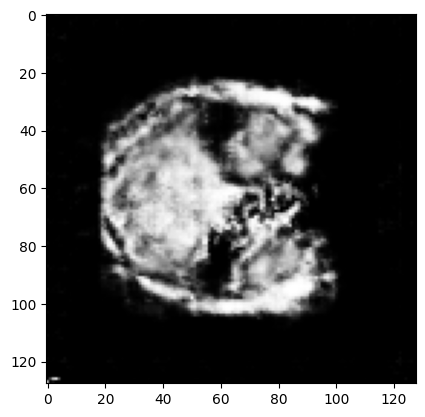

In [74]:
# --- Now you can use the generator with loaded weights ---
# Example of generating images:
if 'generator' in locals() and not generator.training:  # Check if generator exists and is in eval mode
    try:
        with torch.no_grad():  # No need to compute gradients during inference
            fixed_noise = torch.randn(64, LATENT_SIZE, device=DEVICE)
            fake_images = generator(fixed_noise).detach().cpu()
            print("Sample images generated by the loaded Generator.")
            # You can save or display fake_images here
            # import torchvision.utils as vutils
            # vutils.save_image(fake_images, "generated_samples_from_loaded_model.png", normalize=True)
            plt.imshow(fake_images[20][0], cmap='gray')
    except Exception as e:
        print(f"Error when generating images with the loaded generator: {e}")
